In [1]:
import pandas as pd
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold, cross_validate, GridSearchCV
import pickle
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Import data and set variables

In [2]:
# Import data
train = pd.read_pickle('~/Documents/Github Repository/early-warning-twitter/Processed datasets/Model data/Train.pkl')

# Split up in X and y columns
X_train = train.loc[:, train.columns != 'has_Incident_Related']
y_train = train[['has_Incident_Related']]

# Variable with the text of a tweet without hashtags 
X_train_text_no_hashtag = X_train.loc[:, 'preprocessed_text_no_hashtag']

# Variable with the text of a tweet with hashtags as normal text
X_train_text = X_train.loc[:, 'preprocessed_text']

# Response variable, whether the tweet is related to an incident (0 or 1)
y_train = y_train.loc[:, 'has_Incident_Related'].astype('int')

# Convert text data into tf-idf

In [3]:
# Convert X_train_text_no_hashtag into tf-idf vectorized matrix
vc_text_no_hashtag = TfidfVectorizer().fit(X_train_text_no_hashtag)
X_train_text_no_hashtag_df = pd.DataFrame(vc_text_no_hashtag.transform(X_train_text_no_hashtag).todense(), columns=vc_text_no_hashtag.get_feature_names())

# Convert X_train_text into tf-idf vectorized matrix
vc_text = TfidfVectorizer().fit(X_train_text)
X_train_text_df = pd.DataFrame(vc_text.transform(X_train_text).todense(), columns=vc_text.get_feature_names())

In [4]:
# Reset index for all variables
X_train_text_no_hashtag_df.reset_index(inplace=True, drop=True)
X_train_text_df.reset_index(inplace=True, drop=True)

In [6]:
parameters = [{'alpha': [1, 0.5, 0.1, 0.05, 0.01]}]

def get_best_parameters(parameters, train, test):
    clf = GridSearchCV(
        MultinomialNB(), parameters, cv=3, scoring='f1', n_jobs=4
    )
    clf.fit(train, test)
    print(clf.best_params_)
    
get_best_parameters(parameters, X_train_text_no_hashtag_df, y_train)
# Result alpha = 0.01

get_best_parameters(parameters, X_train_text_df, y_train)
# Result alpha = 0.01

{'alpha': 0.01}
{'alpha': 0.01}


In [7]:
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)
clf_nb1 = MultinomialNB(alpha=0.01)
scores1 = cross_validate(clf_nb1, X_train_text_no_hashtag_df, y_train, cv=k_fold, scoring='f1', return_train_score=True, n_jobs=4, verbose=1)

print("Model trained on text of the tweet without hashtag")
print("Train score: ", scores1["train_score"].mean())
print("Test score: ", scores1["test_score"].mean())
print("-----------------------------")

clf_nb2 = MultinomialNB(alpha=0.01)
scores2 = cross_validate(clf_nb2, X_train_text_df, y_train, cv=k_fold, scoring='f1', return_train_score=True, n_jobs=4, verbose=1)

print("Model trained on text of the tweet with hashtag as normal text")
print("Train score: ", scores2["train_score"].mean())
print("Test score: ", scores2["test_score"].mean())
print("-----------------------------")

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    4.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Model trained on text of the tweet without hashtag
Train score:  0.9435684975035645
Test score:  0.8453218792542112
-----------------------------
Model trained on text of the tweet with hashtag as normal text
Train score:  0.9458058289368789
Test score:  0.8502204758685489
-----------------------------


[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    4.5s finished


In [8]:
clf_nb1.fit(X_train_text_no_hashtag_df, y_train)
clf_nb2.fit(X_train_text_df, y_train)

MultinomialNB(alpha=0.01)

In [16]:
# Save models
pickle.dump(clf_nb1, open('Models/naive-bayes-1.sav', 'wb'))
pickle.dump(clf_nb2, open('Models/naive-bayes-2.sav', 'wb'))

In [9]:
# Load models
clf_nb1 = pickle.load(open('Models/naive-bayes-1.sav', 'rb'))
clf_nb2 = pickle.load(open('Models/naive-bayes-2.sav', 'rb'))

In [10]:
# Import the Test data
test = pd.read_pickle('~/Documents/Github Repository/early-warning-twitter/Processed datasets/Model data/Test.pkl')

X_test = test.loc[:, test.columns != 'has_Incident_Related']
y_test = test[['has_Incident_Related']]

# Variable with the text of a tweet without hashtags 
X_test_text_no_hashtag = X_test.loc[:, 'preprocessed_text_no_hashtag']

# Variable with the text of a tweet with hashtags as normal text
X_test_text = X_test.loc[:, 'preprocessed_text']

# Response variable, whether the tweet is related to an incident (0 or 1)
y_test = y_test.loc[:, 'has_Incident_Related'].astype('int')

In [11]:
# Convert X_test_text_no_hashtag into tf-idf vectorized matrix
X_test_text_no_hashtag_df = pd.DataFrame(vc_text_no_hashtag.transform(X_test_text_no_hashtag).todense(), columns=vc_text_no_hashtag.get_feature_names())

# Convert X_test_text into tf-idf vectorized matrix
X_test_text_df = pd.DataFrame(vc_text.transform(X_test_text).todense(), columns=vc_text.get_feature_names())

# Reset index for all variables
X_test_text_no_hashtag_df.reset_index(inplace=True, drop=True)
X_test_text_df.reset_index(inplace=True, drop=True)

In [15]:
def predict_data(model, test_data, test_y):
    # predict the new document from the testing dataset
    y_pred = model.predict(test_data)

    # Predict the probabilities for the testing dataset (necessary for AUC)
    y_pred_prob = model.predict_proba(test_data)

    # compute the performance measures
    score1 = metrics.accuracy_score(test_y, y_pred)
    print("accuracy:   %0.3f" % score1)

    print(metrics.classification_report(test_y, y_pred,
                                                target_names=['Negative', 'Positive'], digits=3))

    print("confusion matrix:")
    print(metrics.confusion_matrix(test_y, y_pred))

    print('------------------------------')

    # Only keep probabilities for the positive outcome only
    y_pred_prob = y_pred_prob[:, 1]

    nb_auc = roc_auc_score(test_y, y_pred_prob)
    print('Naive Bayes: ROC AUC=%.3f' % (nb_auc))
    nb_fpr, nb_tpr, _ = roc_curve(test_y, y_pred_prob)
    plt.plot(nb_fpr, nb_tpr, marker='.', label='Naive Bayes')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()
    print("-------------------------------------")

accuracy:   0.939
              precision    recall  f1-score   support

    Negative      0.948     0.969     0.959      1014
    Positive      0.914     0.859     0.885       382

    accuracy                          0.939      1396
   macro avg      0.931     0.914     0.922      1396
weighted avg      0.939     0.939     0.939      1396

confusion matrix:
[[983  31]
 [ 54 328]]
------------------------------
Naive Bayes: ROC AUC=0.973


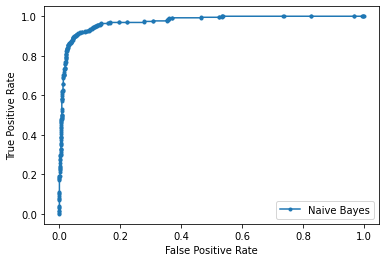

-------------------------------------
accuracy:   0.937
              precision    recall  f1-score   support

    Negative      0.949     0.965     0.957      1014
    Positive      0.904     0.861     0.882       382

    accuracy                          0.937      1396
   macro avg      0.926     0.913     0.920      1396
weighted avg      0.936     0.937     0.936      1396

confusion matrix:
[[979  35]
 [ 53 329]]
------------------------------
Naive Bayes: ROC AUC=0.974


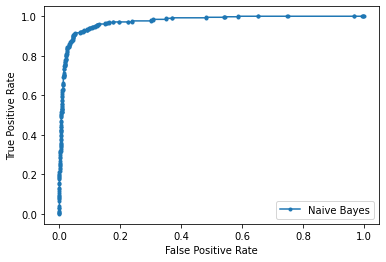

-------------------------------------


In [16]:
predict_data(clf_nb1, X_test_text_no_hashtag_df, y_test)
predict_data(clf_nb2, X_test_text_df, y_test)